# <span style="font-width:bold; font-size: 3rem; color:#2656a3;">**Data Engineering and Machine Learning Operations in Business** </span> <span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## <span style='color:#2656a3'> 🗒️ This notebook is divided into the following sections:

1. Load new batch data.
2. Predict using model from Model Registry.

## <span style='color:#2656a3'> ⚙️ Import of libraries and packages

We start by accessing the folder we have created that holds the functions we need for electricity prices, weather measures, and calendar. Then, we proceed to import all the necessary libraries needed for this notebook and warnings to avoid unnecessary distractions and keep output clean.

In [1]:
# First we go one back in our directory to access the folder with our functions
%cd ..

# Now we import the functions from the features folder
# This is the functions we have created to generate features for electricity prices and weather measures
from features import electricity_prices, weather_measures, calendar 

# We go back into the notebooks folder
%cd notebooks

/Users/camillahannesbo/Documents/AAU/Master - BDS/2. semester/Data Engineering and Machine learning operations in Business/MLOPs-Assignment-
/Users/camillahannesbo/Documents/AAU/Master - BDS/2. semester/Data Engineering and Machine learning operations in Business/MLOPs-Assignment-/notebooks


In [2]:
# Importing the packages for the needed libraries for the Jupyter notebook
import joblib
#import inspect 
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
#from matplotlib.ticker import FuncFormatter
#import os

#%config InlineBackend.figure_format='retina'
#%matplotlib inline

## <span style="color:#2656a3;"> 📡 Connecting to Hopsworks Feature Store
We connect to the Hopsworks Feature Store so we can retrieve the Feature View, access the Model Registry, and retrieve the saved model from training.

In [3]:
# Importing the hopsworks module
import hopsworks

# Logging in to the Hopsworks project
project = hopsworks.login()

# Getting the feature store from the project
fs = project.get_feature_store() 

/opt/anaconda3/envs/mlops/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/550040
Connected. Call `.close()` to terminate connection gracefully.


### <span style='color:#2656a3'> ⚙️ Feature View Retrieval

In [4]:
# Retrieve the 'electricity_training_feature_view' feature view
feature_view_training = fs.get_feature_view(
    name='electricity_training_feature_view',
    version=1,
)

### <span style='color:#2656a3'> 🗄 Model Registry

In [5]:
# Retrieve the model registry
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


## <span style='color:#2656a3'> 📮 Retrieving model from Model Registry

In [6]:
# Retrieving the model from the Model Registry
retrieved_model = mr.get_model(
    name="electricity_price_prediction_model", 
    version=1,
)

# Downloading the saved model to a local directory
saved_model_dir = retrieved_model.download()

# Loading the saved XGB model
retrieved_xgboost_model = joblib.load(saved_model_dir + "/dk_electricity_model.pkl")

In [7]:
# Display the retrieved XGBoost Regressor model
retrieved_xgboost_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style='color:#2656a3'> ✨ Load New Data
Our objective is to predict the electricity prices for the upcoming days, therefore we load a weather forecast as batch data to make predictions.

In [8]:
# Fetching weather forecast measures for the next 5 days
weather_forecast_df = weather_measures.forecast_weather_measures(
    forecast_length=5
)

# Fetching danish calendar
calendar_df = calendar.dk_calendar()

# Merging the weather forecast and calendar dataframes
new_data = pd.merge(weather_forecast_df, calendar_df, how='inner', left_on='date', right_on='date')

# Displaying the new data
new_data.tail()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,timestamp,datetime,date,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
115,1715281200000,2024-05-09 19:00:00,2024-05-09,19,11.7,87.0,0.0,0.0,0.0,3.0,99.0,18.9,38.2,3,9,5,2024,0
116,1715284800000,2024-05-09 20:00:00,2024-05-09,20,11.3,89.0,0.0,0.0,0.0,3.0,97.0,18.7,38.9,3,9,5,2024,0
117,1715288400000,2024-05-09 21:00:00,2024-05-09,21,11.0,91.0,0.0,0.0,0.0,3.0,96.0,18.6,40.0,3,9,5,2024,0
118,1715292000000,2024-05-09 22:00:00,2024-05-09,22,10.8,92.0,0.0,0.0,0.0,3.0,96.0,18.2,39.2,3,9,5,2024,0
119,1715295600000,2024-05-09 23:00:00,2024-05-09,23,10.6,93.0,0.0,0.0,0.0,3.0,96.0,17.7,38.2,3,9,5,2024,0


In [9]:
# Drop columns 'date', 'datetime', and 'timestamp' from the DataFrame 'new_data'
data = new_data.drop(columns=['date', 'datetime', 'timestamp'])

# Displaying the last 5 rows of the modified DataFrame
data.tail()

,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
115,19,11.7,87.0,0.0,0.0,0.0,3.0,99.0,18.9,38.2,3,9,5,2024,0
116,20,11.3,89.0,0.0,0.0,0.0,3.0,97.0,18.7,38.9,3,9,5,2024,0
117,21,11.0,91.0,0.0,0.0,0.0,3.0,96.0,18.6,40.0,3,9,5,2024,0
118,22,10.8,92.0,0.0,0.0,0.0,3.0,96.0,18.2,39.2,3,9,5,2024,0
119,23,10.6,93.0,0.0,0.0,0.0,3.0,96.0,17.7,38.2,3,9,5,2024,0


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [10]:
# Make predictions on the batch data using the retrieved XGBoost Regressor model
predictions = retrieved_xgboost_model.predict(data)

See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


In [11]:
# Make predictions on the new data using the retrieved XGBoost Regressor model
predictions_data = {
    'prediction': predictions,
    'time': new_data["datetime"],
}

# Create a DataFrame from the predictions data
predictions_df = pd.DataFrame(predictions_data)

# Display the predictions
predictions_df

,prediction,time
0,0.674561,2024-05-05 00:00:00
1,0.632812,2024-05-05 01:00:00
2,0.622411,2024-05-05 02:00:00
3,0.600384,2024-05-05 03:00:00
4,0.600384,2024-05-05 04:00:00
...,...,...
115,0.196045,2024-05-09 19:00:00
116,0.196045,2024-05-09 20:00:00
117,0.196045,2024-05-09 21:00:00
118,0.196045,2024-05-09 22:00:00


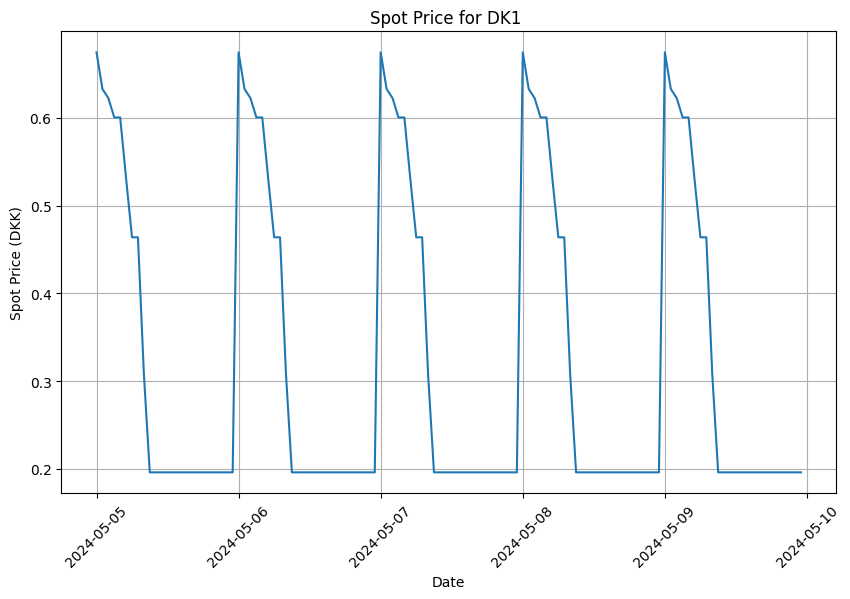

In [12]:
# Group the data by date and calculate the average temperature for each day
daily_data = predictions_df.groupby('time')['prediction'].mean()
 
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(daily_data.index, daily_data.values)
plt.xlabel('Date')
plt.ylabel('Spot Price (DKK)')
plt.title('Spot Price for DK1 ')
plt.xticks(rotation=45)
plt.grid(True)
 
# Show the plot
plt.show()

In [13]:
# Create Altair chart with line and dots
chart = alt.Chart(predictions_df).mark_line(point=True).encode(
    x='time:T', 
    y='prediction:Q', 
    # Adding tooltips for interactive information display
    tooltip=[alt.Tooltip('time:T', title='Date', format='%Y-%m-%d'), 
             alt.Tooltip('time:T', title='Time', format='%H:%M'), 
             alt.Tooltip('prediction:Q', title='Spot Price (DKK)', format='.2f')
            ]
)
 
# Display the chart
chart.interactive()

alt.Chart(...)

---
## <span style="color:#ff5f27;">👾 Next is creating our Streamlit App</span>